In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


np.random.seed(42)
warnings.filterwarnings('ignore')

##### Delar från del1: Funktion och metoder. t.ex. ladda data, grund stats. Beräkningar osv..
##### T.ex. statistik medelvärde och midian för (ålder, blodtry, kolesterol och vikt).

In [35]:
def visa_statistik(df):
    kolumner = ["age", "systolic_bp", "cholesterol", "weight" ]
    for kol in kolumner:
        print(f"{kol}: medel={df[kol].mean():.1f}, median={df[kol].median():.1f}")

def skapa_grafer(df):
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    num_kol = ["age", "weight", "systolic_bp", "cholesterol"]
    sns.heatmap(df[num_kol].corr(), annot=True, ax=axs[0, 0])
    
    axs[0, 0].set_title('Korrelationsmatris')
    axs[0, 1].scatter(df["age"], df["systolic_bp"], alpha=0.5)
    axs[0, 1].set_title("Ålder vs Systolic blodtryck")
    axs[0, 1].set_xlabel('Ålder')
    axs[0, 1].set_ylabel("Systolic_bp")
    axs[1, 0].boxplot(
        [df[df["sex"]=="M"]["systolic_bp"],
         df[df["sex"]=="F"]["systolic_bp"]],
         labels=["Män", "Kvinnor"])

    axs[1, 0].set_title('Blodtryck per kön')
    
    sjukdom_per_kön = df.groupby("sex")["disease"].mean() * 100

    axs[1, 1].bar(sjukdom_per_kön.index, sjukdom_per_kön.values)
    axs[1, 1].set_title("Andel sjukdom per kön (%)")
    axs[1, 1].set_ylabel('Procent')
    
    plt.tight_layout()
    plt.show()

df = pd.read_csv('health_study_dataset.csv')
print(df.head())
df.info()

   id  age sex  height  weight  systolic_bp  cholesterol smoker  disease
0   1   57   F   168.9    65.8        141.8         4.58     No        0
1   2   47   M   180.4    95.9        144.8         5.18    Yes        0
2   3   59   F   169.9    82.2        151.7         6.16     No        0
3   4   72   M   157.7    93.1        151.0         6.63     No        0
4   5   46   M   192.6   104.1        144.1         5.21     No        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int6

##### Simulering av sjukdomsandel: koden beräknar andelen med sjukdom i ett DataFrame, simulerar binär data med samma sannolikhet och jämför andelarna



In [36]:
sjuckdom_grupp = df["disease"].mean()
print(f"Andel med sjukdom:{sjuckdom_grupp:3f}")

np .random.seed(42)
simulerad = np.random.binomial(n=1, p=sjuckdom_grupp, size=1000)
andel_simulerad =np.mean(simulerad)
print(f"andel med sjukdom i simulerad data: {andel_simulerad:3f}")

differens = sjuckdom_grupp - andel_simulerad
print(f"Skillnaden i andel med sjukdom mellan verklig och simulerad data: {differens:3f}")

Andel med sjukdom:0.058750
andel med sjukdom i simulerad data: 0.056000
Skillnaden i andel med sjukdom mellan verklig och simulerad data: 0.002750


##### Denna klass tillhandshåller metoder för att: bland annat Beräkna beskrivande statistik. Klassen HealthAnalys analys för grund data som (blodtryck, ålder, vikt, osv..). Gör linjär regression. Utföra PCA analys.

In [37]:
class HealsAnalyz:

    def __init__(self, data):
        self.data = data

    def sammanfattning(self):
        return{
            "antal": len(self.data),
            "antal_sjuk": self.data["disease"].mean() * 100,
            "medelålder": self.data["age"].mean()
        }
    
    def regression(self, x_kol, y_kol):
        x = self.data[[x_kol]] if isinstance(x_kol, str) else self.data[x_kol]
        y =self.data[y_kol]

        
        model = LinearRegression()
        model.fit(x, y)

        return {
            "r2": model.score(x, y),
            "koeff": model.coef_,
            "intercept": model.intercept_
        }
   
analysator = HealsAnalyz(df)
print("sammanfattning:")
for nyckel, värde in analysator.sammanfattning().items():
        print(f"{nyckel}: {värde}")

sammanfattning:
antal: 800
antal_sjuk: 5.875
medelålder: 49.42625


##### Linjer algebra - Regression: För att förutsäga blodtryck från ålder och vikt

In [38]:
print("\nREGRESSION ANALYS:")

reg1 = analysator.regression('age', 'systolic_bp')
print(f"Ålder -> Blodtryck: R² = {reg1['r2']:.3f}")

reg2 = analysator.regression(['age', 'weight'], 'systolic_bp')
print(f"Ålder + Vikt -> Blodtryck: R² = {reg2['r2']:.3f}")


REGRESSION ANALYS:
Ålder -> Blodtryck: R² = 0.369
Ålder + Vikt -> Blodtryck: R² = 0.405





##### Linjer Algebra - PCA (Principal Component Analys), analys för hälsodata. Automatisk analys av vad PC1 och PC2 representerar.
##### PCA Resultat: Skapar en spläntsdiagram av de PCA komponenterna.
##### PCA1 är den linjära kombination av ursprunliga variabler (ålder, blodtryck, kolerserol och vikt)
Medan PCA2 är och en linjär kombination av ursprunliga variabler fast i vinkelrät mot PCA1.


PCA ANALYS:
PC1 förlkarar 54% av variansen
PC2 förlkarar 33.9% av variansen


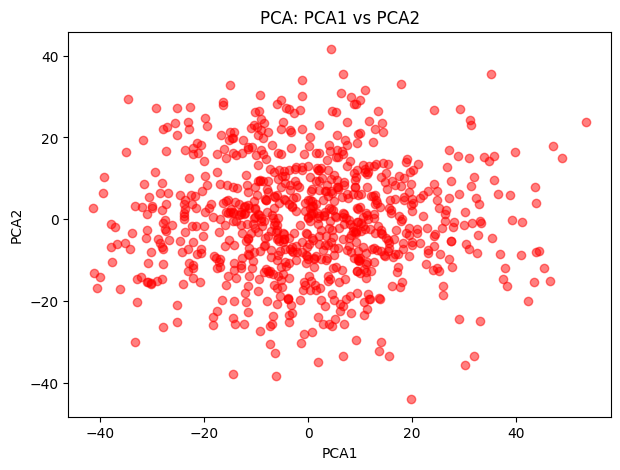

In [39]:
print("\nPCA ANALYS:")
from sklearn.decomposition import PCA

num_data = df[['age', 'systolic_bp', 'cholesterol', 'weight']].dropna()

pca =PCA(n_components=2)
pca_result = pca.fit_transform(num_data)

print(f"PC1 förlkarar {pca.explained_variance_ratio_[0]*100:.0f}% av variansen")
print(f"PC2 förlkarar {pca.explained_variance_ratio_[1]*100:.1f}% av variansen")

plt.figure(figsize=(7, 5))

plt.scatter(pca_result[:,0], pca_result[:,1], color='red', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA: PCA1 vs PCA2')
plt.show()



#### Utökad Analys: Analyserar hälsodata för att se Sjukdomrisk per åldersgrupp. Den jämför blodtryck mellan män och kvinnor. Den undersöker Vikt för friska och sjuka. Stapeldiagram visar sjukdomsrisk per ålder. Medan Boxplot visar vikt för friska och sjuka.


UTÖKAD ANALYS:
Sjukdomrisk per ålder:
 <40: 4.5%

Blodtryck:
män=150.2
kvinnor=148.1


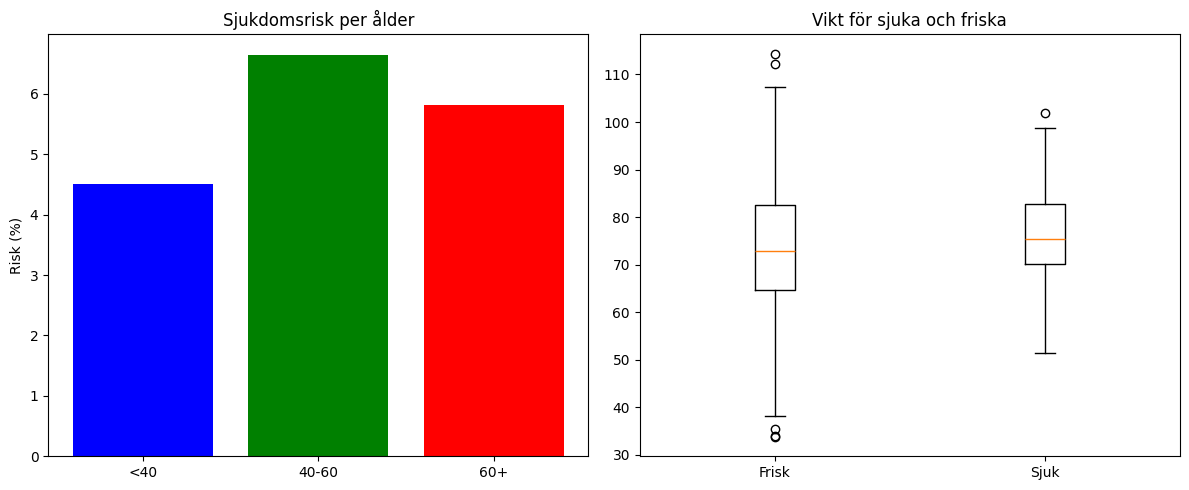

0      40-60
1      40-60
2      40-60
3        60+
4      40-60
       ...  
795      60+
796    40-60
797    40-60
798    40-60
799    40-60
Name: åldersgräns, Length: 800, dtype: category
Categories (3, object): ['<40' < '40-60' < '60+']
 40-60: 6.7%

Blodtryck:
män=150.2
kvinnor=148.1


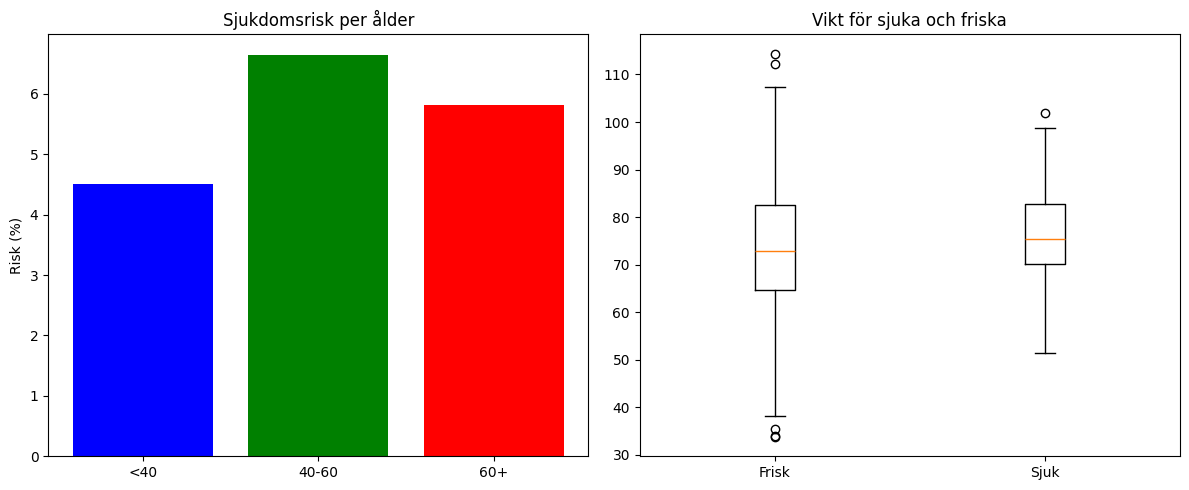

0      40-60
1      40-60
2      40-60
3        60+
4      40-60
       ...  
795      60+
796    40-60
797    40-60
798    40-60
799    40-60
Name: åldersgräns, Length: 800, dtype: category
Categories (3, object): ['<40' < '40-60' < '60+']
 60+: 5.8%

Blodtryck:
män=150.2
kvinnor=148.1


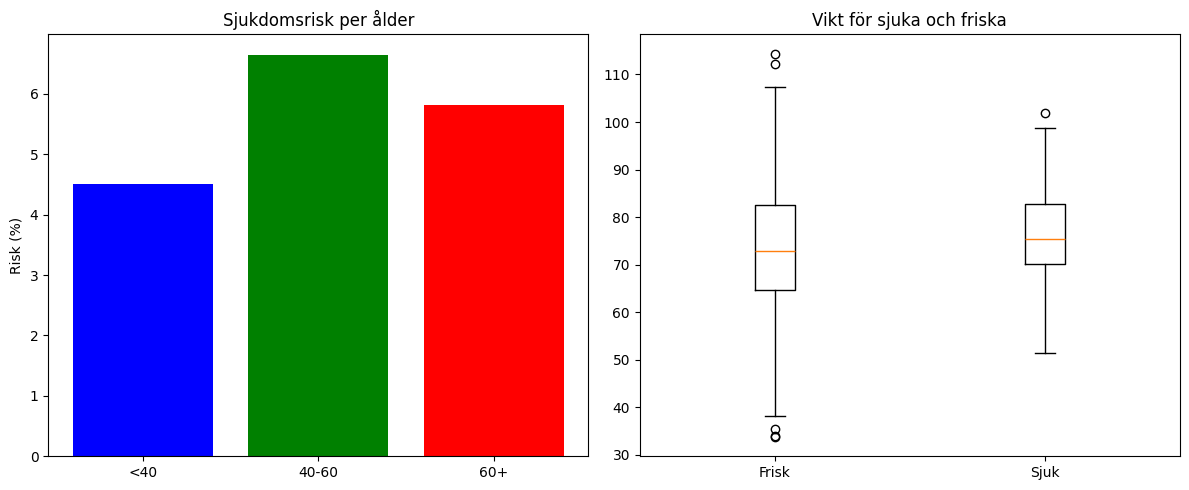

0      40-60
1      40-60
2      40-60
3        60+
4      40-60
       ...  
795      60+
796    40-60
797    40-60
798    40-60
799    40-60
Name: åldersgräns, Length: 800, dtype: category
Categories (3, object): ['<40' < '40-60' < '60+']


In [40]:

print("\nUTÖKAD ANALYS:")
df['åldersgräns'] =pd.cut(
    df['age'], bins=[0, 40, 60, 100], 
    labels=['<40', '40-60', '60+'])

sjuk_per_ålder = df.groupby('åldersgräns')['disease'].mean() * 100
print("Sjukdomrisk per ålder:")

for ålder, risk in sjuk_per_ålder.items():
    print(f" {ålder}: {risk:.1f}%")

    bp_män = df[df['sex']=='M']['systolic_bp'].mean()
    bp_kvinnor = df[df['sex']=='F']['systolic_bp'].mean()
    print('\nBlodtryck:')
    print(f'män={bp_män:.1f}')
    print(f'kvinnor={bp_kvinnor:.1f}')

    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    colors = ['blue', 'green', 'red']

    ax1.bar(sjuk_per_ålder.index.astype(str), sjuk_per_ålder.values, color=colors)
    ax1.set_title('Sjukdomsrisk per ålder')
    ax1.set_ylabel('Risk (%)')

    ax2.boxplot([df[df['disease'] == 0]['weight'],
                 df[df['disease'] ==1 ]['weight']],
                 labels=['Frisk', 'Sjuk']
                 )
    ax2.set_title('Vikt för sjuka och friska')

    plt.tight_layout()
    plt.show()
    print(df.åldersgräns)